In [1]:
import pandas as pd
import numpy as np
from darts import TimeSeries
from darts.models import TCNModel
from darts.metrics import mse, rmse, r2_score, mae, smape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank
)
import json
import shap
from numpy.lib.stride_tricks import sliding_window_view
from darts.explainability.explainability_result import ComponentBasedExplainabilityResult

In [8]:
result_path = 'results/TCN/'

In [3]:
target_columns = [
    'Temperature','Precipitation_accumulated','Humidity', 'Wind_Speed_kmh',
    'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin', 'Wind_Dir_Cos'
]

df = pd.read_csv("data/ground_station_clean.csv")

In [4]:
encoders = {
    "cyclic":{
        "past":["month","dayofyear","day","hour","minute"],
    },
    "transformer": Scaler()
}

In [5]:
best_r2 = float('-inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_forecasts = None
# Define model parameters

# Set up time series cross-validation with 5 folds, respecting temporal order of data
tscv = TimeSeriesSplit(n_splits=5)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=10, verbose=True)
    pl_trainer_kwargs = {
        "accelerator": "auto",
        "callbacks": [early_stopper],
    }
    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTraining the model...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")

    scaler = Scaler()
    # Fit the scaler only on training data to avoid data leakage
    scaler = scaler.fit(train_fold)
    # Transform all time series
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)


    model = TCNModel(
         model_name=f"model_{fold+1}",
        input_chunk_length=20,
        output_chunk_length=1,
        n_epochs=30,
        batch_size=29,
        num_filters=109,
        kernel_size=2,
        num_layers=6,
        dilation_base=5,
        weight_norm=True,
        dropout=0.15531203611947797,
        add_encoders=encoders,
        pl_trainer_kwargs=pl_trainer_kwargs,
        loss_fn=torch.nn.HuberLoss(),
        lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_kwargs={"mode":"min", "factor":0.5, "patience":4, "min_lr":1e-6},
        save_checkpoints=True,
        show_warnings=True,
        force_reset=True, # Importante para que cada iteração treine do zero com este model_name
        optimizer_kwargs={"lr": 0.0002474912028329941, "weight_decay": 1e-5},
    )
    model.fit(
        series=[train_scaled],
        val_series=val_scaled,
        dataloader_kwargs={"num_workers": 11}
    )

    model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{fold+1}/", best=True)

    # Generate historical forecasts to evaluate model performance on past data
    forecasts = model.historical_forecasts(
        train_scaled,
        start=0.8,
        forecast_horizon=1,
        stride=1,
        retrain=False,
        last_points_only=True,
    )


    forecasts_t = scaler.inverse_transform(forecasts)
    s = scaler.inverse_transform(train_scaled).split_after(0.8)[1]

    r2_geral = r2_score(s, forecasts_t)
    print(f"O R2 desse fold foi {r2_geral}")
    if best_r2 < r2_geral:
        best_r2 = r2_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold foi {best_fold}")



Fold 1

Training the model...
Train set: 1389 samples
Validation set: 1384 samples


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('AMD Radeon RX 6700 XT') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | HuberLoss        | 0      | train
1 | train_criterion | HuberLoss        | 0      | train
2 | val_criterion   | HuberLoss        | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | res_blocks      | ModuleList       | 248 K  | train
-------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 7.729


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.411 >= min_delta = 0.001. New best score: 7.318


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.001. New best score: 7.302


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.027 >= min_delta = 0.001. New best score: 7.275


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.065 >= min_delta = 0.001. New best score: 7.210


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.113 >= min_delta = 0.001. New best score: 7.097


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 7.095


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.071 >= min_delta = 0.001. New best score: 7.024


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.087 >= min_delta = 0.001. New best score: 6.937


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 6.937. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | HuberLoss        | 0      | train
1 | train_criterion | Hube

O R2 desse fold foi -1.2844908247507285

Fold 2

Training the model...
Train set: 2773 samples
Validation set: 1384 samples


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.008


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.006


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.005


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.005. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | HuberLoss        | 0      | train
1 | train_criterion | Hube

O R2 desse fold foi 0.9085851895887271

Fold 3

Training the model...
Train set: 4157 samples
Validation set: 1384 samples


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.003


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.001


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.001. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type    

O R2 desse fold foi -inf

Fold 4

Training the model...
Train set: 5541 samples
Validation set: 1384 samples


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.012


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.010


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.009


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.008


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss = nan is not finite. Previous best value was 0.008. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2928: RuntimeWarning: Mean of empty slice
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: invalid value encountered in divide
/home/eduardo/Documentos/Water-Cycle-Neural-

O R2 desse fold foi nan

Fold 5

Training the model...
Train set: 6925 samples
Validation set: 1384 samples


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.016


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.014


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.013


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.013. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


O R2 desse fold foi 0.3155141494637076
O melhor fold foi 2


In [6]:
model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{best_fold}/", best=True)

TCNModel(output_chunk_shift=0, kernel_size=2, num_filters=109, num_layers=6, dilation_base=5, weight_norm=True, dropout=0.15531203611947797, model_name=model_2, input_chunk_length=20, output_chunk_length=1, n_epochs=30, batch_size=29, add_encoders={'cyclic': {'past': ['month', 'dayofyear', 'day', 'hour', 'minute']}, 'transformer': Scaler}, pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7fd8cb783320>]}, loss_fn=HuberLoss(), lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'factor': 0.5, 'patience': 4, 'min_lr': 1e-06}, save_checkpoints=True, show_warnings=True, force_reset=True, optimizer_kwargs={'lr': 0.0002474912028329941, 'weight_decay': 1e-05})

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting time series verification for consistency...

Performance metrics:
                                    MSE        RMSE         MAE        R2  \
Temperature                    3.880568    1.969916    1.422433  0.914062   
Precipitation_accumulated    102.711121   10.134650    5.834485  0.997527   
Humidity                      14.195359    3.767673    2.535252  0.925176   
Wind_Speed_kmh                 0.041549    0.203836    0.139866  0.862851   
Soil_Moisture              41869.351343  204.620017  132.434395  0.968116   
Soil_Temperature               6.459376    2.541530    1.493060  0.859889   
Wind_Dir_Sin                   0.063791    0.252570    0.165876  0.813692   
Wind_Dir_Cos                   0.098743    0.314234    0.184836  0.844320   

                               SMAPE  
Temperature                 9.775199  
Precipitation_accumulated  16.780140  
Humidity                    3.380735  
Wind_Speed_kmh             86.519012  
Soil_Moisture               1.862624

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/TCN//previsao_vs_real_1.png


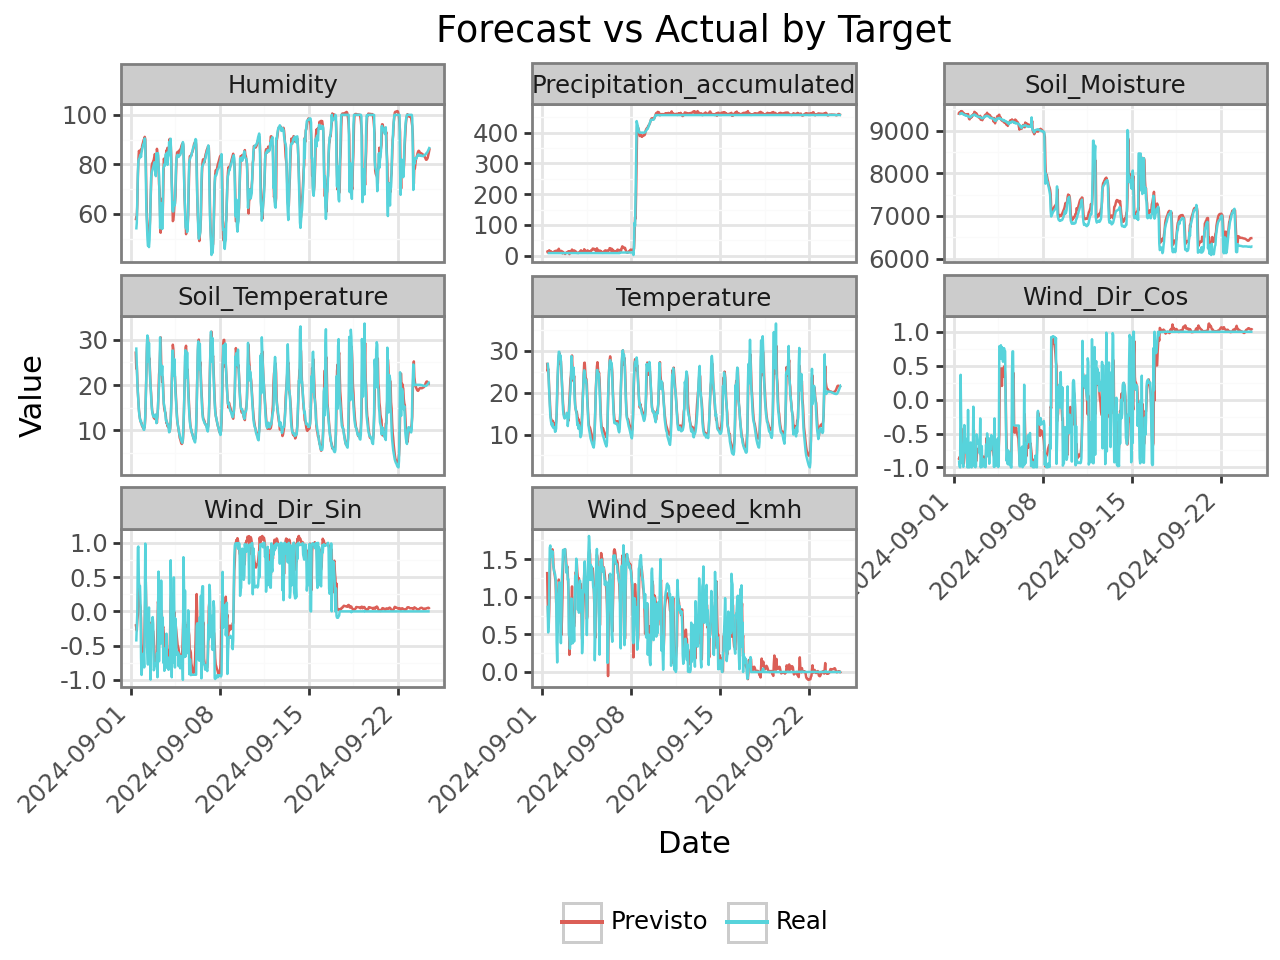

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [ ]:
for forecast_horizon in [1,6,12,24,48,72,168]:
    forecasts = model.historical_forecasts(
        best_train_scaled,
        start=0.8,
        forecast_horizon=forecast_horizon,
        stride=1,
        retrain=False,
        last_points_only=True,
        predict_kwargs={"dataloader_kwargs":{"num_workers": 11}}
    )

    forecasts_t = best_scaler.inverse_transform(forecasts)
    s = best_scaler.inverse_transform(best_train_scaled).split_after(0.8)[1]
    metrics = {}
    print("Starting time series verification for consistency...")
    for target in target_columns:
        metrics[target] = {
            'MSE': mse(s[target], forecasts_t[target]),
            'RMSE': rmse(s[target], forecasts_t[target]),
            'MAE': mae(s[target], forecasts_t[target]),
            'R2': r2_score(s[target], forecasts_t[target]),
            'SMAPE': smape(s[target], forecasts_t[target]),
        }
    metrics_df = pd.DataFrame(metrics).T
    print("\nPerformance metrics:")
    print(metrics_df)

    s_df = s.to_dataframe()
    s_df = s_df.reset_index()
    forecasts_t_df = forecasts_t.to_dataframe()
    forecasts_t_df = forecasts_t_df.reset_index()
    forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})
    print(forecasts_t_df.columns)

    plot_columns = ['Timestamp'] + target_columns
    s_melted = s_df[plot_columns].melt(
        id_vars='Timestamp',
        var_name='target_column',
        value_name='value'
    )
    s_melted['type'] = 'Real'

    forecasts_t_melted = forecasts_t_df[plot_columns].melt(
        id_vars='Timestamp',
        var_name='target_column',
        value_name='value'
    )
    forecasts_t_melted['type'] = 'Previsto'

    # Concatena os DataFrames 'Real' e 'Previsto'
    df_combined = pd.concat([s_melted, forecasts_t_melted])

    # Opcional: Renomear a coluna de índice para algo mais descritivo, se for data/hora
    df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

    plot = (
            ggplot(df_combined, aes(x='Date', y='value', color='type'))
            + geom_line()
            + facet_wrap('~ target_column', scales='free_y') # Creates a subplot for each 'target_column'
            + labs(
        title='Forecast vs Actual by Target',
        x='Date',
        y='Value',
        color='Data Type' # Legend for color
    )
            + theme_bw()
            + theme(
        axis_text_x=element_text(rotation=45, hjust=1), # Rotates x-axis labels
        legend_position='bottom', # Places legend at the bottom
        legend_title=element_blank(), # Removes legend title
    )
    )

    plot.save(f'{result_path}/previsao_vs_real_{forecast_horizon}.png', width=12, height=10, dpi=300)
    plot.show()

    with open(f'{result_path}/metrics_{forecast_horizon}.json', 'w') as f:
        json.dump(metrics_df.to_dict(), f, indent=4)


In [ ]:
pred = model.predict(
    n=24,
    verbose=True
)

pred.t = best_scaler.inverse_transform(pred)
pred_df = pred.to_dataframe()
pred_df = pred_df.reset_index()
pred_df = pred_df.rename(columns={"time": "Timestamp"})

plot_columns = ['Timestamp'] + target_columns
pred_melted = pred_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)

plot = (
        ggplot(pred_melted, aes(x='Timestamp', y='value', color='target_column'))
        + geom_line()
        + facet_wrap('~ target_column', scales='free_y') # Creates a subplot for each 'target_column'
        + labs(
    title='Forecast by Target',
    x='Date',
    y='Value',
    color='Data Type' # Legend for color
)
        + theme_bw()
        + theme(
    axis_text_x=element_text(rotation=45, hjust=1), # Rotates x-axis labels
    legend_position='bottom', # Places legend at the bottom
    legend_title=element_blank(), # Removes legend title

)
)
plot.show()
plot.save(f'{result_path}/pred_future_24.png', width=12, height=10, dpi=300)
